# Initialization

In [31]:
from lmfit import models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Functions

In [32]:
from operator import add
from functools import reduce

def read_xps_data_from_excel(file, sheet_name, skiprows=7):
    raw = pd.read_excel(file, sheet_name=sheet_name, skiprows=skiprows)

    try:
        new = pd.DataFrame()
        new['BindingEnergy'] = raw['B. E.']
        new['Counts'] = raw['Counts']
        new['FitRegion_BindingEnergy'] = raw['PkGrp1_BE']
        new['FitBackground'] = raw['PkGrp1_Count']
        new['FitEnvelope'] = raw['PkFitEnv1']
        
        #Search for variable number of peaks
        peaki = 1
        while True:
            try:
                new['Peak{}'.format(peaki)] = raw['Pk0{}'.format(peaki)]
                peaki += 1
            except KeyError:
                break
    except KeyError:
        print('File does not match peak finding pattern Pk01, Pk02, ..., returning raw columns')
        new = pd.DataFrame()
        new['BindingEnergy'] = raw['B. E.']
        new['Counts'] = raw['Counts']
        for k in raw.keys():
            if k != 'B. E.' and k != 'Count':
                new[k] = raw[k]
    return new

def plot_xps_data_matplotlib(xpsdataframe):
    plt.plot(xpsdataframe['BindingEnergy'], xpsdataframe['Counts'], label='AllData')
    
    x = xpsdataframe['FitRegion_BindingEnergy']
    for k in xpsdataframe.keys()[3:]:
        plt.plot(x, xpsdataframe[k], label=k)
        
    plt.legend()
    plt.xlabel('Binding Energy (eV)')
    plt.gca().invert_xaxis()
    plt.show()

def take_energy_range(energies, data, erange):
    indices = (energies >= erange[0]) & (energies <= erange[1])
    return np.array([energies[indices], data[indices]])

def get_background_subtracted_data(xpsdataframe):
    croppednans = xpsdataframe['FitRegion_BindingEnergy'][pd.notna(xpsdataframe['FitRegion_BindingEnergy'])]
    upper = croppednans.iloc[0]
    lower = croppednans.iloc[-1]
    energies, data = take_energy_range(xpsdataframe['BindingEnergy'], xpsdataframe['Counts'], [lower, upper])
    assert (energies - croppednans < 1e-10).all(), 'Energy grid of BindingEnergy and FitRegion_BindingEnergy did not match'
    new = {}
    new['BindingEnergy'] = energies
    new['Counts'] = data - xpsdataframe['FitBackground'][pd.notna(xpsdataframe['FitBackground'])]
    return pd.DataFrame(new)

def doublet_peakshape_model(mainpeakpos=120, gamma=0.15, sigma=0.35, splitting=-0.84, ratio=2, prefix='a'):
    """Makes lmfit model of doublet shape.
    
    Model is composed of two voigts with fixed Lorentzian
     and Gaussian widths and fixed splitting and peak ratios.

    Args:
        mainpeakpos: Energy (eV) position of main peak.
        gamma: Lorentzian width (in voigt model).
        sigma: Gaussian width (in voigt model).
        splitting: Energy gap (eV) between the two components
        ratio: Ratio of peak heights a1/a2

    Returns:
        lmfit model, lmfit pars

    Raises:
        Nothing.
    """
    prefix1 = prefix + '1_'
    prefix2 = prefix + '2_'
    mod = models.VoigtModel(prefix=prefix1)+models.VoigtModel(prefix=prefix2)
    pars = mod.make_params()
    parsdict = dict([[prefix2+'amplitude',{'expr': prefix1+'amplitude*'+str(1/ratio), 'value': 1/ratio, 'vary': False}],
                     [prefix2+'gamma', {'expr': prefix1+'gamma', 'value': gamma, 'vary': False}],
                     [prefix2+'center', {'expr': prefix1+'center-'+str(splitting), 'value': mainpeakpos-splitting, 'vary': False}],
                     [prefix1+'sigma', {'expr': '', 'value': sigma, 'vary': False}],
                     [prefix1+'gamma', {'expr': '', 'value': gamma, 'vary': False}],
                     [prefix1+'center', {'expr': '', 'value': mainpeakpos, 'vary': True}],
                     [prefix2+'sigma', {'expr': prefix1+'sigma', 'value': sigma, 'vary': False}]])
    for k,v in parsdict.items():
        pars[k].set(vary=v['vary'],expr=v['expr'])
    for k,v in parsdict.items():
        pars[k].value=v['value']
    return mod, pars

def multiple_doublet_model(centralenergies, relativeintensities):
    assert len(centralenergies) == len(relativeintensities), 'Intensities and energies must have same length.'
    models = []
    parslist = []
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    for i in range(len(centralenergies)):
        mod, pars = doublet_peakshape_model(centralenergies[i], prefix=alphabet[i])
        pars[alphabet[i]+'1_amplitude'].set(value=relativeintensities[i])
        models.append(mod)
        parslist.append(pars)
    totalmodel = reduce(add, models)
    totalpars = reduce(add, parslist)
    return totalmodel, totalpars

def xps_fit(xpsdataframe, centralenergies, relativeintensities):
    bgsub = get_background_subtracted_data(xpsdataframe)
    energies = bgsub['BindingEnergy']
    data = bgsub['Counts']
    mod, pars = multiple_doublet_model(centralenergies, relativeintensities)
    for k in pars.keys():
        if '1_amplitude' in k:
            pars[k].set(value=data.max() * pars[k].value)
    fit = mod.fit(data, params=pars, x=energies)
    return fit, mod, pars

def plot_xps_fit(fit, showallcomponents=False):
    x = fit.userkws['x']
    plt.plot(x, fit.data, label='Data')
    plt.plot(x, fit.eval(x=x), label='Fit')
    components = fit.eval_components(x=x)
    
    uniqueprefixes = sorted(list(set([s[:-2] for s in components.keys()])))
    for p in uniqueprefixes:
        plt.plot(x, components[p+'1_'] + components[p+'2_'], label=p)
        
    if showallcomponents:
        for k, v in components.items():
            plt.plot(x, v, 'k--', alpha=0.5)
        
    plt.legend()
    plt.xlabel('Binding Energy')
    plt.gca().invert_xaxis()
    plt.ylabel('Intensity')
    plt.show()

def calculate_component_percentages(fit):
    components = fit.eval_components()
    uniqueprefixes = sorted(list(set([s[:-2] for s in components.keys()])))
    intensities = {}
    for p in uniqueprefixes:
        intensities[p] = np.sum(components[p+'1_'] + components[p+'2_'])
    total = np.sum(list(intensities.values()))
    for k, v in intensities.items():
        intensities[k] = v / total
    return intensities

# Example usage

## import data using pandas

Import data from Excel file and specific sheet

In [33]:
data = read_xps_data_from_excel('/mnt/c/Users/Christine/Documents/School/Work/Data/XPS/20180703/CHC-086 - all.xlsx',
                                sheet_name='Sheet11')

Import oxidized P data from Excel file (for comparison/calibration)

In [34]:
ambientdata = read_xps_data_from_excel('/mnt/c/Users/Christine/Documents/School/Work/Data/XPS/20180601/BP 2d ambient - survey.xlsx',
                                       sheet_name='Sheet7')

Plot the data to view it:

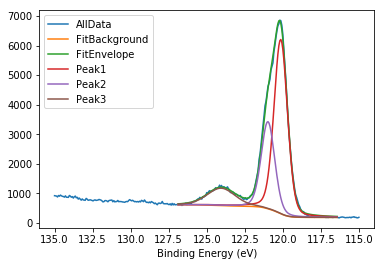

In [28]:
plot_xps_data_matplotlib(data)

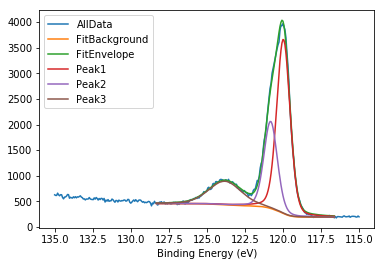

In [29]:
plot_xps_data_matplotlib(ambientdata)